In [48]:
import pickle
import cv2
import numpy as np
import gzip

import torch
from torchvision import models
# from ultralytics import YOLO

labels = ['1 RIBU ASLI', '1 RIBU PALSU', '10 RIBU ASLI', '10 RIBU PALSU',
         '100 RIBU ASLI', '100 RIBU PALSU', '20 RIBU ASLI', '20 RIBU PALSU',
         '5 RIBU ASLI', '5 RIBU PALSU', '50 RIBU ASLI', '50 RIBU PALSU']

def load_pickle(file_path):
    with open(file_path, 'rb') as file:
        return pickle.load(file)

# microtext
def extract_microtext(image_gray):
    edges = cv2.Canny(image_gray, 50, 150)
    return np.sum(edges) / edges.size

# warna
def extract_color(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hue_mean = np.mean(hsv[:, :, 0])
    sat_mean = np.mean(hsv[:, :, 1])
    val_mean = np.mean(hsv[:, :, 2])

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    intensity_mean = np.mean(gray)

    red_mean = np.mean(image[:, :, 2])
    green_mean = np.mean(image[:, :, 1])
    blue_mean = np.mean(image[:, :, 0])

    return hue_mean, sat_mean, val_mean, intensity_mean, red_mean, green_mean, blue_mean

# benang pengaman
def detect_thread(image_gray):
    _, thresh = cv2.threshold(image_gray, 128, 255, cv2.THRESH_BINARY)
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 15))
    thread = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, vertical_kernel)
    return np.sum(thread) / thread.size


def extract_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray=cv2.equalizeHist(gray)
    microtext_density = extract_microtext(gray)
    hue, saturation, value, intensity, red, green, blue = extract_color(image)
    thread_density = detect_thread(gray)
    return [microtext_density, hue, saturation, value, intensity, red, green, blue, thread_density]


class ResNet50(torch.nn.Module):
    def __init__(self):
        super(ResNet50, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = torch.nn.Linear(in_features=2048, out_features=12)

    def forward(self, x):
        return self.resnet(x)

class VGG19(torch.nn.Module):
    def __init__(self):
        super(VGG19, self).__init__()
        self.vgg19 = models.vgg19(pretrained=True)
        self.vgg19.fc = torch.nn.Linear(in_features=2048, out_features=12)
        # self.resnet.compile()

    def forward(self, x):
        return self.vgg19(x)

def load_pt(model_name=None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if model_name == "ResNet50":
        model = ResNet50()
        model.load_state_dict(torch.load('/content/sample_data/resnet50-4.pth', map_location=device))
        model.to(device)
        model.eval()
    elif model_name == "YoLoV11":
        model = YOLO("last-4.pt")
    else:
        raise ValueError("Unsupported model name. Use 'ResNet50' or 'YoLoV11'.")
    return model


In [49]:
model = load_pt('ResNet50')

<ipython-input-48-0facacb0a958>:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/sample_data/resnet50-4.pth', map_location=device

In [44]:
path="/content/drive/MyDrive/CompVis Projek/UANGUVTERBARU/test/"
import os
def load_dataset_with_folder_structure(folder_path,augment=True):
    images_folder = os.path.join(folder_path, "images")
    labels_folder = os.path.join(folder_path, "labels")

    data = []
    labels = []
    count=0

    for img_name in os.listdir(images_folder):
        if img_name.endswith(".jpg"):
            img_path = os.path.join(images_folder, img_name)
            label_path = os.path.join(labels_folder, os.path.splitext(img_name)[0] + ".txt")

            img = cv2.imread(img_path)
            if img is not None and os.path.exists(label_path):
                resized_img = cv2.resize(img, (512, 512))
                data.append(resized_img)

                with open(label_path, "r") as f:
                    first_line = f.readline().strip()
                    class_index = int(first_line.split()[0])
                    labels.append(class_index)


    return np.asarray(data, dtype=np.uint8), np.array(labels, dtype=np.int32)
x_test, y_test=load_dataset_with_folder_structure(path, False)

In [45]:
from torch.utils.data import DataLoader, Dataset
class MoneyDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        image = self.x[idx]
        label = self.y[idx]

        if self.transform:
            image = self.transform(image)
            label = torch.tensor(label)

        return image, label

In [46]:
from torchvision import transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
transform = transforms.Compose([
    transforms.ToTensor()
])
test_dataset = MoneyDataset(x_test, y_test, transform)

In [47]:
test_loader = DataLoader(test_dataset)

In [50]:
correct = 0
total = 0
import torch.nn.functional as F
y_true = []
y_pred = []


loss_function = nn.CrossEntropyLoss()
losses=[]
accuracies=[]
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to('cpu')
        labels = labels.to('cpu')
        labels = labels.type(torch.LongTensor)
        labels = F.one_hot(labels, num_classes=12).float()

        outputs = model(images)
        # print(outputs)
        loss = loss_function(outputs, labels)
        losses.append(loss.item())
        predicted = torch.argmax(outputs.data, 1)

        accuracy = (predicted == labels).sum().item() / labels.size(0)
        accuracies.append(accuracy)
        total += labels.size(0)
        correct += (predicted == torch.argmax(labels)).sum().item()
        print(f"predicted: {predicted}, actual: {torch.argmax(labels)}")

print(correct)
print(total)
print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))


predicted: tensor([4]), actual: 4
predicted: tensor([10]), actual: 10
predicted: tensor([4]), actual: 4
predicted: tensor([8]), actual: 8
predicted: tensor([4]), actual: 4
predicted: tensor([4]), actual: 4
predicted: tensor([8]), actual: 8
predicted: tensor([4]), actual: 4
predicted: tensor([4]), actual: 4
predicted: tensor([6]), actual: 6
predicted: tensor([4]), actual: 4
predicted: tensor([4]), actual: 4
predicted: tensor([4]), actual: 4
predicted: tensor([4]), actual: 4
predicted: tensor([4]), actual: 4
predicted: tensor([4]), actual: 4
predicted: tensor([6]), actual: 6
predicted: tensor([4]), actual: 4
predicted: tensor([4]), actual: 4
predicted: tensor([10]), actual: 10
predicted: tensor([10]), actual: 10
predicted: tensor([4]), actual: 4
predicted: tensor([4]), actual: 4
predicted: tensor([6]), actual: 6
predicted: tensor([6]), actual: 6
predicted: tensor([4]), actual: 4
predicted: tensor([6]), actual: 6
predicted: tensor([10]), actual: 10
predicted: tensor([6]), actual: 6
predic

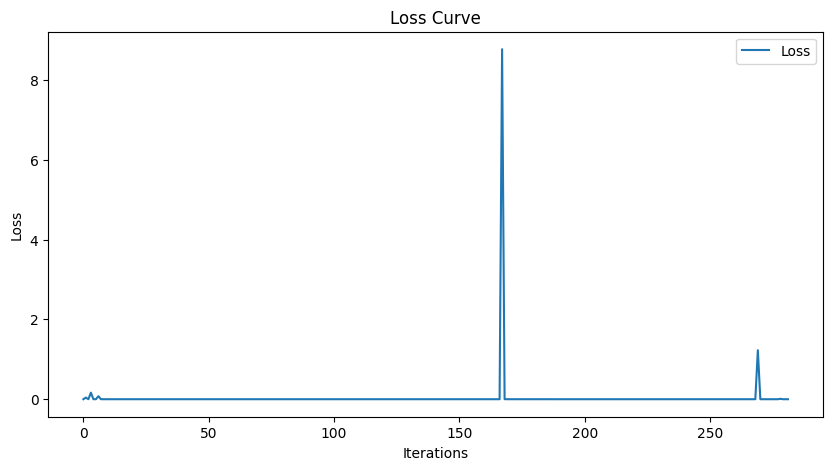

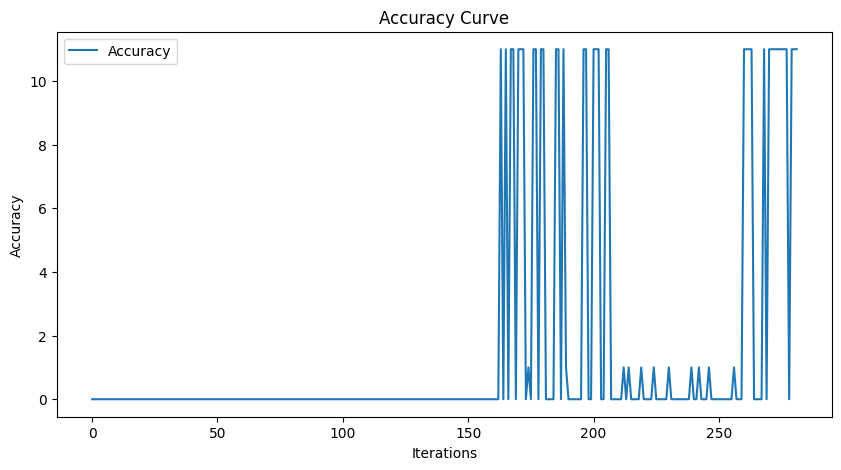

In [51]:
import matplotlib.pyplot as plt

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(losses, label="Loss")
plt.title("Loss Curve")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(accuracies, label="Accuracy")
plt.title("Accuracy Curve")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [ ]:
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to('cpu')
        labels = labels.to('cpu')

        outputs = model(images)
        predicted = torch.argmax(outputs, 1)

        y_true.extend(labels.tolist())
        y_pred.extend(predicted.tolist())


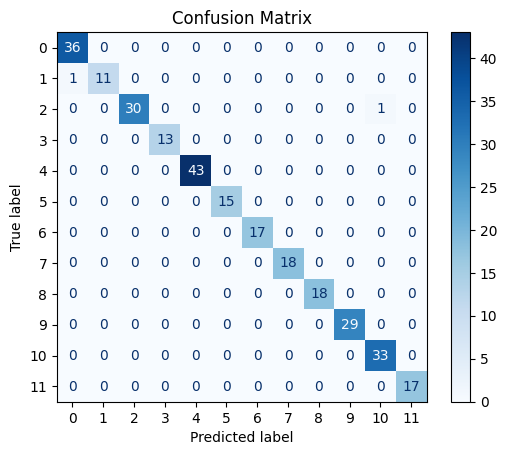

In [55]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [59]:
from sklearn.metrics import classification_report



classification_report(y_pred, y_true)

'              precision    recall  f1-score   support\n\n           0       1.00      0.97      0.99        37\n           1       0.92      1.00      0.96        11\n           2       0.97      1.00      0.98        30\n           3       1.00      1.00      1.00        13\n           4       1.00      1.00      1.00        43\n           5       1.00      1.00      1.00        15\n           6       1.00      1.00      1.00        17\n           7       1.00      1.00      1.00        18\n           8       1.00      1.00      1.00        18\n           9       1.00      1.00      1.00        29\n          10       1.00      0.97      0.99        34\n          11       1.00      1.00      1.00        17\n\n    accuracy                           0.99       282\n   macro avg       0.99      1.00      0.99       282\nweighted avg       0.99      0.99      0.99       282\n'

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        37
           1       0.92      1.00      0.96        11
           2       0.97      1.00      0.98        30
           3       1.00      1.00      1.00        13
           4       1.00      1.00      1.00        43
           5       1.00      1.00      1.00        15
           6       1.00      1.00      1.00        17
           7       1.00      1.00      1.00        18
           8       1.00      1.00      1.00        18
           9       1.00      1.00      1.00        29
          10       1.00      0.97      0.99        34
          11       1.00      1.00      1.00        17

    accuracy                           0.99       282
   macro avg       0.99      1.00      0.99       282
weighted avg       0.99      0.99      0.99       282
